In [10]:
test_run = True

train_set_path = (
    "/home/jbct/Projects/thesis/db-ocsvm/data/processed/NSL-KDD/train_set.csv"
)
test_set_path = (
    "/home/jbct/Projects/thesis/db-ocsvm/data/processed/NSL-KDD/test_set.csv"
)

if test_run:
    use_sample = True
    train_frac = 0.1
else:
    use_sample = False

Test set

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

test_set = pd.read_csv(test_set_path)
print(f"test set count: {test_set.shape[0]:,}")
test_set.head(3)
# Splitting into X and y
X_test = test_set.drop(
    columns=["attack_binary", "attack_categorical", "attack_class"]
).values
y_test = test_set["attack_binary"].values
y_test_class = test_set["attack_class"]

test set count: 11,271


Train set

In [12]:
train_dataset = pd.read_csv(train_set_path)

if use_sample:
    train_dataset = train_dataset.sample(frac=train_frac, random_state=1)

print(f"train set count: {train_dataset.shape[0]:,}")
train_dataset.head(3)

train set count: 6,734


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
51444,0.0,3.616817e-06,0.002149,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
65414,0.0,5.023357e-07,0.000011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4203,0.0,2.578657e-06,0.000068,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Training

In [13]:
from sklearn.svm import OneClassSVM

ocsvm = OneClassSVM(kernel="rbf", gamma="auto", nu=0.2, verbose=True)

ocsvm.fit(train_dataset.values)

[LibSVM].
*
optimization finished, #iter = 1245
obj = 848556.503564, rho = 1269.968463
nSV = 1348, nBSV = 1346


OneClassSVM(gamma='auto', nu=0.2, verbose=True)

# Testing

Perform prediction

In [14]:
y_pred = ocsvm.predict(X_test)

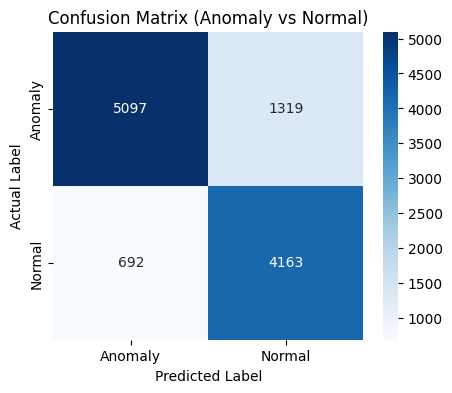

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=[-1, 1])


def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    plt.show()


plot_confusion_matrix(cm, ["Anomaly", "Normal"], "Confusion Matrix (Anomaly vs Normal)")

In [16]:
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Anomaly", "Normal"]))

precision = precision_score(y_test, y_pred, pos_label=-1)
recall = recall_score(y_test, y_pred, pos_label=-1)
f1 = f1_score(y_test, y_pred, pos_label=-1)
acc = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {acc}")

Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.88      0.79      0.84      6416
      Normal       0.76      0.86      0.81      4855

    accuracy                           0.82     11271
   macro avg       0.82      0.83      0.82     11271
weighted avg       0.83      0.82      0.82     11271

Precision: 0.8804629469683883
Recall: 0.7944201995012469
F1 Score: 0.8352314625153625
Accuracy: 0.8215774997781918


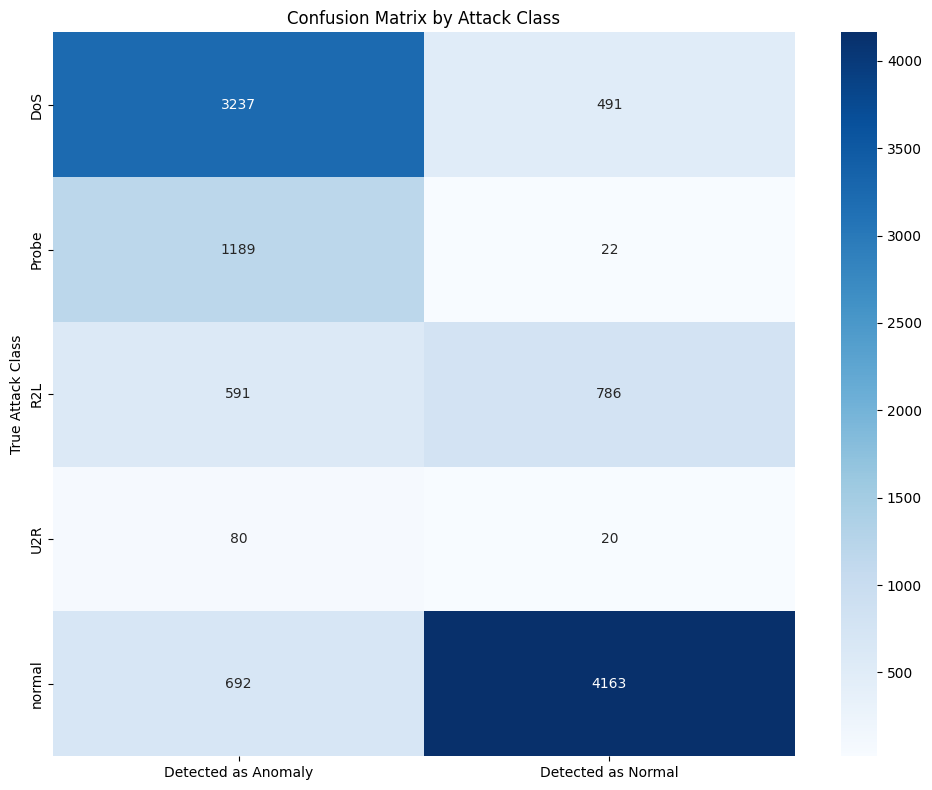

In [17]:
import numpy as np


def create_multiclass_cm(y_true_class, y_pred_binary):
    """
    Create a confusion matrix showing how each attack class was classified.

    For attack classes (DoS, Probe, R2L, U2R), correct detection is when y_pred = -1 (anomaly)
    For normal class, correct detection is when y_pred = 1 (normal)
    """
    classes = np.unique(y_true_class)
    cm = np.zeros((len(classes), 2))

    for i, cls in enumerate(classes):
        # Get predictions for this class
        cls_indices = y_true_class == cls
        preds = y_pred_binary[cls_indices]

        # Count correct and incorrect predictions
        if cls == "normal":
            cm[i, 0] = np.sum(preds == -1)  # incorrectly detected as anomaly
            cm[i, 1] = np.sum(preds == 1)  # correctly detected as normal
        else:
            cm[i, 0] = np.sum(preds == -1)  # correctly detected as anomaly
            cm[i, 1] = np.sum(preds == 1)  # incorrectly detected as normal

    return cm, classes


# Create and plot the multi-class confusion matrix
cm_multi, classes = create_multiclass_cm(y_test_class, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_multi,
    annot=True,
    fmt="g",
    cmap="Blues",
    xticklabels=["Detected as Anomaly", "Detected as Normal"],
    yticklabels=classes,
)
plt.ylabel("True Attack Class")
plt.title("Confusion Matrix by Attack Class")
plt.tight_layout()
plt.show()

In [18]:
# Calculate detection rates for each class
print("Detection rates by class:")
class_metrics = {}
for cls in np.unique(y_test_class):
    # Get indices for this class
    class_indices = y_test_class == cls

    # True values and predictions for this class
    y_true_cls = y_test[class_indices]
    y_pred_cls = y_pred[class_indices]

    # Calculate metrics
    if cls == "Normal":
        # For normal class, we want to detect 1 (normal)
        correct = np.sum((y_pred_cls == 1))
        precision = precision_score(
            y_true_cls, y_pred_cls, pos_label=1, zero_division=0
        )
        recall = recall_score(y_true_cls, y_pred_cls, pos_label=1, zero_division=0)
    else:
        # For attack classes, we want to detect -1 (anomaly)
        correct = np.sum((y_pred_cls == -1))
        precision = precision_score(
            y_true_cls, y_pred_cls, pos_label=-1, zero_division=0
        )
        recall = recall_score(y_true_cls, y_pred_cls, pos_label=-1, zero_division=0)

    total = len(y_pred_cls)
    detection_rate = correct / total
    f1 = f1_score(
        y_true_cls, y_pred_cls, pos_label=-1 if cls != "Normal" else 1, zero_division=0
    )

    class_metrics[cls] = {
        "detection_rate": detection_rate,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "count": total,
        "correctly_detected": correct,
    }

    print(f"{cls}: {detection_rate:.4f} ({correct}/{total})")

Detection rates by class:
DoS: 0.8683 (3237/3728)
Probe: 0.9818 (1189/1211)
R2L: 0.4292 (591/1377)
U2R: 0.8000 (80/100)
normal: 0.1425 (692/4855)
